In [19]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.metrics import accuracy_score
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [20]:
train = pd.read_csv('datasets/MNIST/mnist_train.csv')
test = pd.read_csv('datasets/MNIST/mnist_test.csv')

train = train.sample(n=20000, random_state=42)

In [21]:
X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]
y_train

12628    7
37730    3
39991    8
8525     9
8279     3
        ..
53300    4
10297    7
4540     4
24701    9
58800    3
Name: label, Length: 20000, dtype: int64

In [22]:
X_train=X_train/255
X_test=X_test/255

In [24]:
y_train.value_counts()

label
1    2240
7    2151
3    2049
6    2003
2    1964
0    1963
9    1961
4    1941
8    1908
5    1820
Name: count, dtype: int64

## Defining the models

In [30]:

models = {
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}  # No hyperparameters for tuning
    },
    'k-NN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 3, 5, 7, 9],  # Odd values for better result
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10, 15, 20],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [None, 10, 20, 30, 40],
            'max_features': ['log2', 'sqrt', None]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=100),
        'params': {
            'C': [0.01, 0.1, 1, 10,100],
            'penalty': ['l2', 'l1'],
            'solver': ['liblinear', 'saga']
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.01, 0.1, 1],
            'kernel': ['rbf', 'poly'], # Using only these two because the other two are guarenteed to get less acc that these two kernels
            'degree': [2, 3, 4]  # Only relevant for poly kernel
        }
    }
}

## Hyperparameter Tuning

In [31]:
overall_best_params = {name: None for name in models.keys()}
overall_best_accuracy = {"model": {name: 0 for name in models.keys()},
                         "ovo": {name: 0 for name in models.keys()},
                         "ovr": {name: 0 for name in models.keys()}}
hyperparam_tuning_times = {name: 0 for name in models.keys()}

for model_name, model_info in models.items():
    print(f"\n--- Running Randomized Search for {model_name} ---")
    model = model_info['model']
    param_grid = model_info['params']
    
    start_time = time.time()
    
    randomized_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    train_time = time.time() - start_time
    hyperparam_tuning_times[model_name] = train_time

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    overall_best_accuracy["model"][model_name] = accuracy
    overall_best_params[model_name] = best_params
    
    print(f"{model_name} - Best Accuracy: {accuracy:.2%}, Hyperparameter Tuning Time: {train_time:.2f}s, Best Params: {best_params}")

    ovo_classifier = OneVsOneClassifier(best_model)
    ovo_classifier.fit(X_train, y_train)
    y_pred_ovo = ovo_classifier.predict(X_test)
    accuracy_ovo = accuracy_score(y_test, y_pred_ovo)
    overall_best_accuracy["ovo"][model_name] = accuracy_ovo

    ovr_classifier = OneVsRestClassifier(best_model)
    ovr_classifier.fit(X_train, y_train)
    y_pred_ovr = ovr_classifier.predict(X_test)
    accuracy_ovr = accuracy_score(y_test, y_pred_ovr)
    overall_best_accuracy["ovr"][model_name] = accuracy_ovr

    print(f"{model_name} - One-vs-One Accuracy: {accuracy_ovo:.2%}")
    print(f"{model_name} - One-vs-Rest Accuracy: {accuracy_ovr:.2%}")

print("\nOverall Best Results for Each Model:")
for model_name in models.keys():
    print(f"{model_name} - Best Accuracy: {overall_best_accuracy['model'][model_name]:.2%}, "
          f"Hyperparameter Tuning Time: {hyperparam_tuning_times[model_name]:.2f}s, "
          f"Best Params: {overall_best_params[model_name]}")



--- Running Randomized Search for Naive Bayes ---


C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Naive Bayes - Best Accuracy: 57.32%, Hyperparameter Tuning Time: 2.66s, Best Params: {}
Naive Bayes - One-vs-One Accuracy: 57.32%
Naive Bayes - One-vs-Rest Accuracy: 21.86%

--- Running Randomized Search for k-NN ---
k-NN - Best Accuracy: 95.87%, Hyperparameter Tuning Time: 175.84s, Best Params: {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'euclidean'}
k-NN - One-vs-One Accuracy: 95.87%
k-NN - One-vs-Rest Accuracy: 95.87%

--- Running Randomized Search for Decision Tree ---
Decision Tree - Best Accuracy: 84.55%, Hyperparameter Tuning Time: 43.08s, Best Params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Decision Tree - One-vs-One Accuracy: 90.31%
Decision Tree - One-vs-Rest Accuracy: 80.17%

--- Running Randomized Search for Random Forest ---
Random Forest - Best Accuracy: 96.10%, Hyperparameter Tuning Time: 874.69s, Best Params: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 40}
Random Forest - One-vs-One Accuracy: 95.81%
Random Forest - One-vs

C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

Logistic Regression - One-vs-One Accuracy: 93.47%
Logistic Regression - One-vs-Rest Accuracy: 91.31%

--- Running Randomized Search for SVM ---
SVM - Best Accuracy: 96.69%, Hyperparameter Tuning Time: 2707.48s, Best Params: {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 1}
SVM - One-vs-One Accuracy: 96.67%
SVM - One-vs-Rest Accuracy: 96.64%

Overall Best Results for Each Model:
Naive Bayes - Best Accuracy: 57.32%, Hyperparameter Tuning Time: 2.66s, Best Params: {}
k-NN - Best Accuracy: 95.87%, Hyperparameter Tuning Time: 175.84s, Best Params: {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'euclidean'}
Decision Tree - Best Accuracy: 84.55%, Hyperparameter Tuning Time: 43.08s, Best Params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Random Forest - Best Accuracy: 96.10%, Hyperparameter Tuning Time: 874.69s, Best Params: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 40}
Logistic Regression - Best Accuracy: 91.90%, Hyperparameter Tuning Time: 797

## Confusion mTrix and Classification report for all the models

<Figure size 800x600 with 0 Axes>

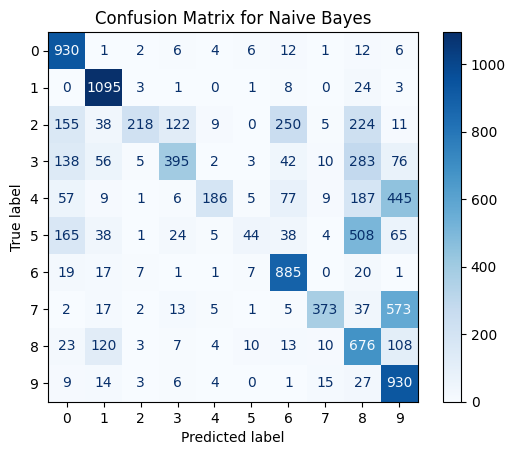


Error Rates for Each Digit in Naive Bayes:
Digit 0: Error Rate = 5.10%
Digit 1: Error Rate = 3.52%
Digit 2: Error Rate = 78.88%
Digit 3: Error Rate = 60.89%
Digit 4: Error Rate = 81.06%
Digit 5: Error Rate = 95.07%
Digit 6: Error Rate = 7.62%
Digit 7: Error Rate = 63.72%
Digit 8: Error Rate = 30.60%
Digit 9: Error Rate = 7.83%

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.62      0.95      0.75       980
           1       0.78      0.96      0.86      1135
           2       0.89      0.21      0.34      1032
           3       0.68      0.39      0.50      1010
           4       0.85      0.19      0.31       982
           5       0.57      0.05      0.09       892
           6       0.66      0.92      0.77       958
           7       0.87      0.36      0.51      1028
           8       0.34      0.69      0.45       974
           9       0.42      0.92      0.58      1009

    accuracy                      

<Figure size 800x600 with 0 Axes>

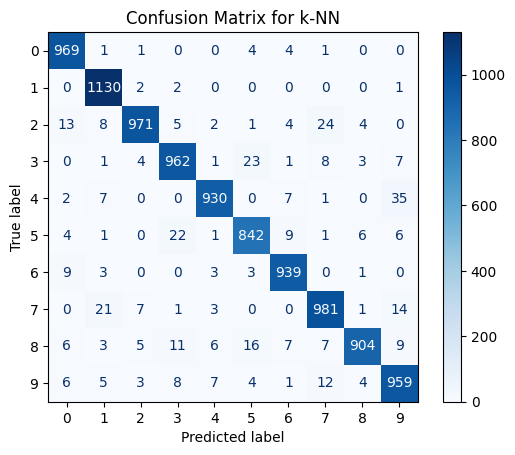


Error Rates for Each Digit in k-NN:
Digit 0: Error Rate = 1.12%
Digit 1: Error Rate = 0.44%
Digit 2: Error Rate = 5.91%
Digit 3: Error Rate = 4.75%
Digit 4: Error Rate = 5.30%
Digit 5: Error Rate = 5.61%
Digit 6: Error Rate = 1.98%
Digit 7: Error Rate = 4.57%
Digit 8: Error Rate = 7.19%
Digit 9: Error Rate = 4.96%

Classification Report for k-NN:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.94      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.98      0.95      0.96       982
           5       0.94      0.94      0.94       892
           6       0.97      0.98      0.97       958
           7       0.95      0.95      0.95      1028
           8       0.98      0.93      0.95       974
           9       0.93      0.95      0.94      1009

    accuracy                           0.96     10000


<Figure size 800x600 with 0 Axes>

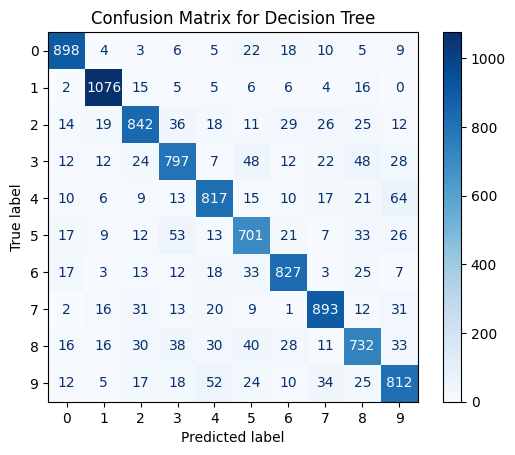


Error Rates for Each Digit in Decision Tree:
Digit 0: Error Rate = 8.37%
Digit 1: Error Rate = 5.20%
Digit 2: Error Rate = 18.41%
Digit 3: Error Rate = 21.09%
Digit 4: Error Rate = 16.80%
Digit 5: Error Rate = 21.41%
Digit 6: Error Rate = 13.67%
Digit 7: Error Rate = 13.13%
Digit 8: Error Rate = 24.85%
Digit 9: Error Rate = 19.52%

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       980
           1       0.92      0.95      0.94      1135
           2       0.85      0.82      0.83      1032
           3       0.80      0.79      0.80      1010
           4       0.83      0.83      0.83       982
           5       0.77      0.79      0.78       892
           6       0.86      0.86      0.86       958
           7       0.87      0.87      0.87      1028
           8       0.78      0.75      0.76       974
           9       0.79      0.80      0.80      1009

    accuracy                

<Figure size 800x600 with 0 Axes>

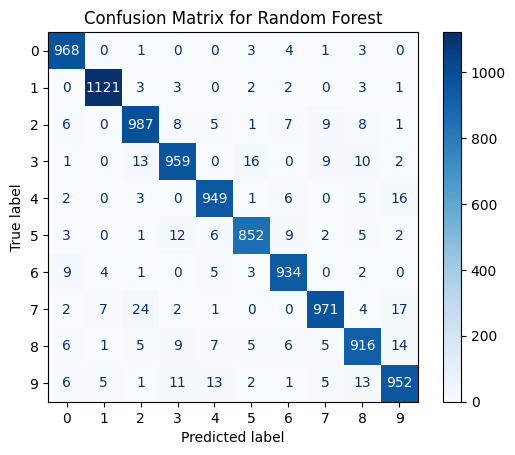


Error Rates for Each Digit in Random Forest:
Digit 0: Error Rate = 1.22%
Digit 1: Error Rate = 1.23%
Digit 2: Error Rate = 4.36%
Digit 3: Error Rate = 5.05%
Digit 4: Error Rate = 3.36%
Digit 5: Error Rate = 4.48%
Digit 6: Error Rate = 2.51%
Digit 7: Error Rate = 5.54%
Digit 8: Error Rate = 5.95%
Digit 9: Error Rate = 5.65%

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.96      0.95      1032
           3       0.96      0.95      0.95      1010
           4       0.96      0.97      0.96       982
           5       0.96      0.96      0.96       892
           6       0.96      0.97      0.97       958
           7       0.97      0.94      0.96      1028
           8       0.95      0.94      0.94       974
           9       0.95      0.94      0.95      1009

    accuracy                        

<Figure size 800x600 with 0 Axes>

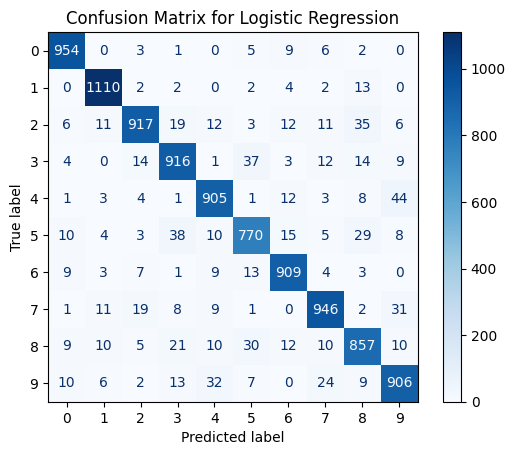


Error Rates for Each Digit in Logistic Regression:
Digit 0: Error Rate = 2.65%
Digit 1: Error Rate = 2.20%
Digit 2: Error Rate = 11.14%
Digit 3: Error Rate = 9.31%
Digit 4: Error Rate = 7.84%
Digit 5: Error Rate = 13.68%
Digit 6: Error Rate = 5.11%
Digit 7: Error Rate = 7.98%
Digit 8: Error Rate = 12.01%
Digit 9: Error Rate = 10.21%

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.89      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.92      0.92       982
           5       0.89      0.86      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.89      0.90      0.90      1009

    accuracy        

<Figure size 800x600 with 0 Axes>

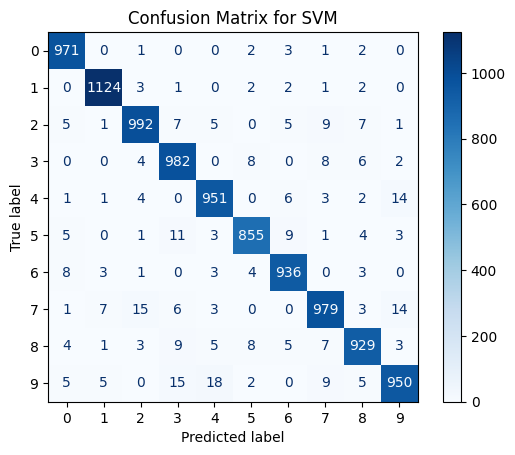


Error Rates for Each Digit in SVM:
Digit 0: Error Rate = 0.92%
Digit 1: Error Rate = 0.97%
Digit 2: Error Rate = 3.88%
Digit 3: Error Rate = 2.77%
Digit 4: Error Rate = 3.16%
Digit 5: Error Rate = 4.15%
Digit 6: Error Rate = 2.30%
Digit 7: Error Rate = 4.77%
Digit 8: Error Rate = 4.62%
Digit 9: Error Rate = 5.85%

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.97      0.98      0.97       958
           7       0.96      0.95      0.96      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.97     10000
  

In [32]:

confusion_matrices = {}
error_rates_per_digit = {name: {} for name in models.keys()}

for model_name, model_info in models.items():
    best_params = overall_best_params[model_name]  # Get the best model parameters

    model = model_info['model'].set_params(**best_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[model_name] = cm
    
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    
    for digit in range(10):
        actual_count = np.sum(cm[digit, :])
        correct_count = cm[digit, digit]     
        error_count = actual_count - correct_count
        error_rate = error_count / actual_count if actual_count > 0 else 0
        error_rates_per_digit[model_name][digit] = error_rate
    
    print(f"\nError Rates for Each Digit in {model_name}:")
    for digit, error_rate in error_rates_per_digit[model_name].items():
        print(f"Digit {digit}: Error Rate = {error_rate:.2%}")
    
    print(f"\nClassification Report for {model_name}:")
    report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)], output_dict=False)
    print(report)


<Figure size 800x600 with 0 Axes>

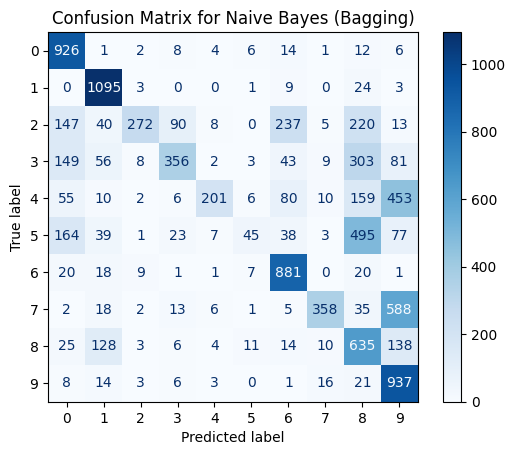


Classification Report for Naive Bayes (Bagging):
              precision    recall  f1-score   support

           0       0.62      0.94      0.75       980
           1       0.77      0.96      0.86      1135
           2       0.89      0.26      0.41      1032
           3       0.70      0.35      0.47      1010
           4       0.85      0.20      0.33       982
           5       0.56      0.05      0.09       892
           6       0.67      0.92      0.77       958
           7       0.87      0.35      0.50      1028
           8       0.33      0.65      0.44       974
           9       0.41      0.93      0.57      1009

    accuracy                           0.57     10000
   macro avg       0.67      0.56      0.52     10000
weighted avg       0.67      0.57      0.53     10000



<Figure size 800x600 with 0 Axes>

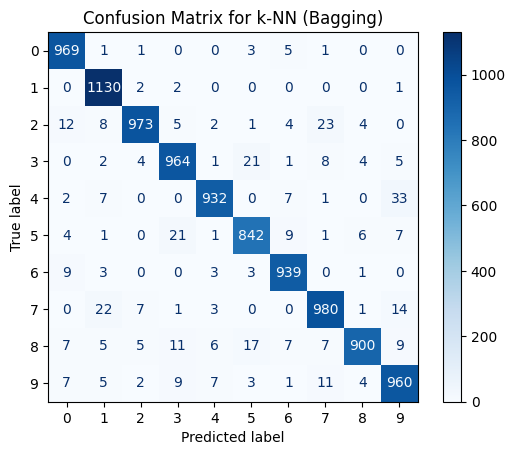


Classification Report for k-NN (Bagging):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.95      1.00      0.97      1135
           2       0.98      0.94      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.98      0.95      0.96       982
           5       0.95      0.94      0.95       892
           6       0.97      0.98      0.97       958
           7       0.95      0.95      0.95      1028
           8       0.98      0.92      0.95       974
           9       0.93      0.95      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



<Figure size 800x600 with 0 Axes>

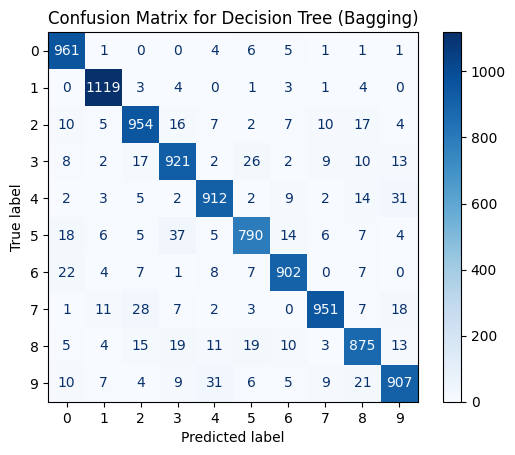


Classification Report for Decision Tree (Bagging):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.96      0.99      0.97      1135
           2       0.92      0.92      0.92      1032
           3       0.91      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.92      0.89      0.90       892
           6       0.94      0.94      0.94       958
           7       0.96      0.93      0.94      1028
           8       0.91      0.90      0.90       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



<Figure size 800x600 with 0 Axes>

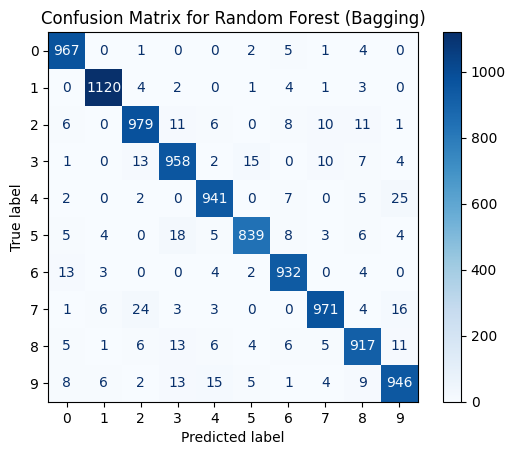


Classification Report for Random Forest (Bagging):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.95      0.94      1010
           4       0.96      0.96      0.96       982
           5       0.97      0.94      0.95       892
           6       0.96      0.97      0.97       958
           7       0.97      0.94      0.96      1028
           8       0.95      0.94      0.94       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sairo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

<Figure size 800x600 with 0 Axes>

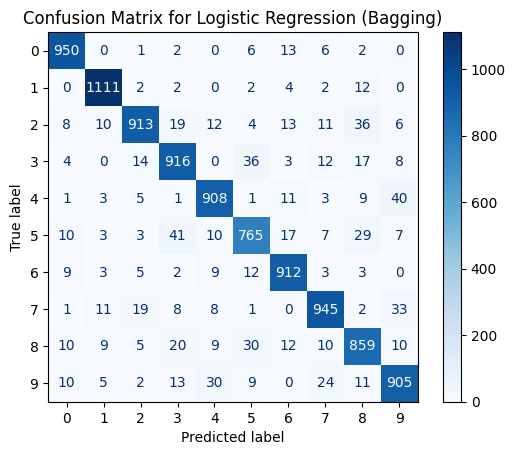


Classification Report for Logistic Regression (Bagging):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.88      0.91      1032
           3       0.89      0.91      0.90      1010
           4       0.92      0.92      0.92       982
           5       0.88      0.86      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



<Figure size 800x600 with 0 Axes>

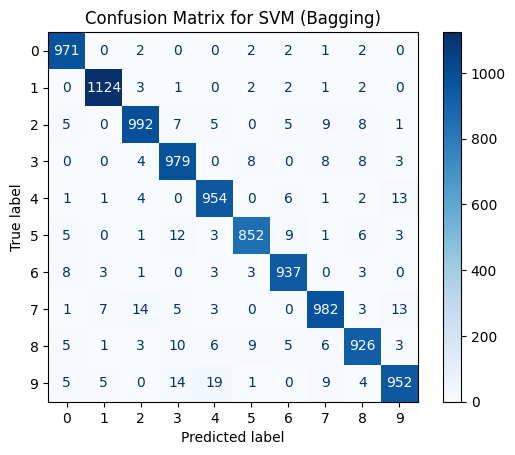


Classification Report for SVM (Bagging):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.97      0.98      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [35]:
confusion_matrices = {}
bagging_acc = []
for model_name, model_info in models.items():
    best_params = overall_best_params[model_name]  # Get the best model parameters

    model = model_info['model'].set_params(**best_params)
    
    bagged_model = BaggingClassifier(estimator=model, n_estimators=15, random_state=42)
    
    bagged_model.fit(X_train, y_train)
    
    y_pred = bagged_model.predict(X_test)

    bagging_acc.append(accuracy_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[model_name] = cm
    
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix for {model_name} (Bagging)")
    plt.show()
    
    print(f"\nClassification Report for {model_name} (Bagging):")
    report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)], output_dict=False)
    print(report)


## Visualizing the Results

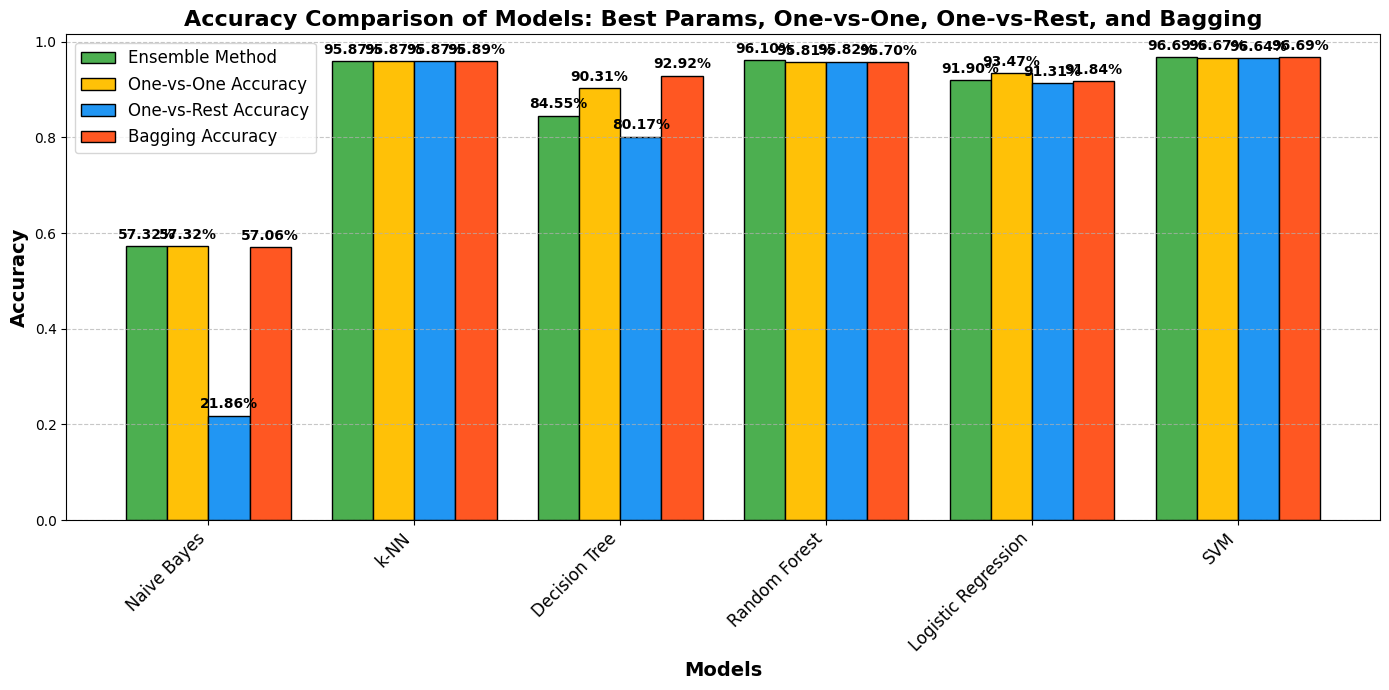

In [45]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(overall_best_accuracy['model'].keys())
best_accuracies = [overall_best_accuracy['model'][model] for model in model_names]
ovo_accuracies = [overall_best_accuracy['ovo'][model] for model in model_names]
ovr_accuracies = [overall_best_accuracy['ovr'][model] for model in model_names]

bar_width = 0.2
indices = np.arange(len(model_names))

colors = ['#4CAF50', '#FFC107', '#2196F3', '#FF5722']

fig, ax = plt.subplots(figsize=(14, 7))

bars_model = ax.bar(indices - 1.5 * bar_width, best_accuracies, bar_width, label='Ensemble Method', color=colors[0], edgecolor='black')
bars_ovo = ax.bar(indices - 0.5 * bar_width, ovo_accuracies, bar_width, label='One-vs-One Accuracy', color=colors[1], edgecolor='black')
bars_ovr = ax.bar(indices + 0.5 * bar_width, ovr_accuracies, bar_width, label='One-vs-Rest Accuracy', color=colors[2], edgecolor='black')
bars_bagging = ax.bar(indices + 1.5 * bar_width, bagging_acc, bar_width, label='Bagging Accuracy', color=colors[3], edgecolor='black')

ax.set_xlabel('Models', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Accuracy Comparison of Models: Best Params, One-vs-One, One-vs-Rest, and Bagging', fontsize=16, fontweight='bold')

ax.set_xticks(indices)
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.legend(loc='upper left', fontsize=12)

for bars in [bars_model, bars_ovo, bars_ovr, bars_bagging]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}', 
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height), 
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', 
                    fontsize=10, color='black', fontweight='bold')

plt.tight_layout()

plt.show()
